In [211]:
import numpy as np
from scipy.stats import multivariate_normal
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
sns.set_style('darkgrid')

In [192]:
#gaussian mixture model function - returns the costs, the responsabilities, 
#the Mean and Cov matrices and the gaussian weights, the Pis

def gmm(X, K=2, max_iters = 20, smoothing = 1e-2):
    N, D = X.shape
    pi = np.ones(K) / K #gaussian weights
    M = np.zeros((K, D)) #means
    C = np.zeros((K, D, D)) #cov matrices
    R = np.zeros((N, K)) #responsabilities
    
    
    # initializing means and covariances
    for i in range(K):
        M[i] = X[np.random.choice(N)]
        C[i] = np.diag(np.ones(D))
        
    costs = np.zeros(max_iters)
    weighted_pdfs = np.zeros((N,K))
    for i in range(max_iters):
        
        #calculating responsabilities
        for k in range(K):
            weighted_pdfs[:,k] = pi[k] * multivariate_normal.pdf(X, mean = M[k], cov = C[k])
        R = weighted_pdfs / weighted_pdfs.sum(axis=1, keepdims=True)

        #calculating new pis, means and covs
        pi = R.sum(axis=0)/N
        M = R.T.dot(X)/ R.sum(axis=0).reshape(K,1)
        for k in range(K):
            C[k] = (X - M[k]).T.dot(R[:,k].reshape(-1,1)*(X - M[k])) / R.sum(axis=0)[k] + np.diag(np.ones(D))*smoothing

        #appending the log-likelihood cost 
        costs[i] = - np.log(weighted_pdfs.sum(axis=1)).sum()   
        if i > 0:
            if np.abs(costs[i] - costs[i-1]) < 0.1:
                break
                
    return costs, R, M, C, pi

In [228]:
#dataset with three gaussians
def gen_dataset():
    mean_1 = np.array([2,8])
    mean_2 = np.array([0,-3])
    mean_3 = np.array([-2,2])

    var_1 = 1.4
    var_2 = 0.9
    var_3 = 0.8

    X = np.random.randn(200,2)*var_1 + mean_1
    X = np.concatenate([X, np.random.randn(200,2)*var_2 + mean_2])
    X = np.concatenate([X, np.random.randn(200,2)*var_3 + mean_3])

    df = pd.DataFrame(X, columns=['X','Y'])
    df['cluster'] = np.concatenate([np.ones(200),np.ones(200)*2,np.ones(200)*3])
    return df

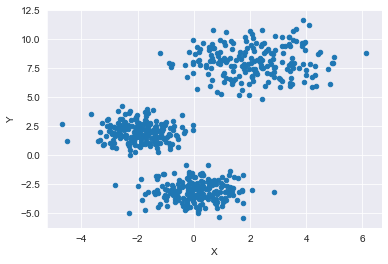

In [229]:
df = gen_dataset()
fig = px.scatter(df, x='X', y='Y', color='cluster')
fig.show()
df.plot.scatter(x='X',y='Y')

In [230]:
X = df.iloc[:,:2].values
costs, R, M, C, pi = gmm(X, K=3, smoothing=1)

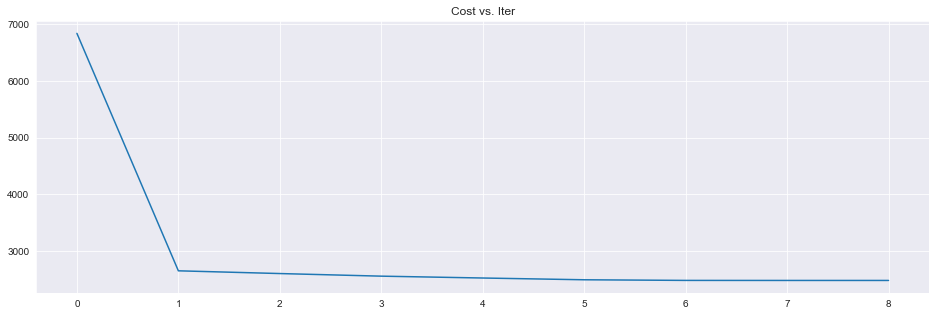

In [231]:
plt.figure(figsize=(16,5))
plt.plot(range(costs[costs>0].size),costs[costs>0])
plt.title('Cost vs. Iter')
plt.show()

In [232]:
#success
df['pred'] = np.argmax(R, axis=1)
fig = px.scatter(df, x='X', y='Y', color='pred')
fig.show()

In [239]:
from matplotlib import cm
from collections import OrderedDict

cmaps = OrderedDict()

cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues']

In [244]:
plt.get_cmap('Greys')

ValueError: 'c' argument must be a mpl color, a sequence of mpl colors or a sequence of numbers, not ['Greys'].

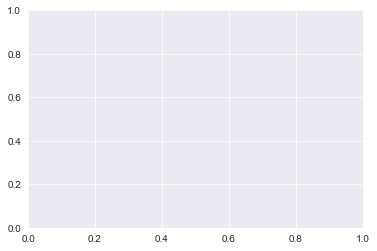

In [245]:
df.plot.scatter(x='X',y='Y',color='Greys')

Comparing the means from the generated normal distributions with the Means found by the GMM, we see that we've pretty much found the correct clusters means:

Means of the generated points: 
* Cluster 1: [2,8]
* Cluster 2: [0,3]
* Cluster 3: [-2,2]

In [233]:
M

array([[ 0.08429499, -3.06215562],
       [ 2.10589335,  8.10163024],
       [-1.90922998,  2.01035865]])

Finally, the normal distributions generated were spherical (diagonal covariances with equal variance values for each axis):
* Variance of cluster 1: 1.4
* Variance of cluster 2: 0.9
* Variance of cluster 3: 0.8

In [234]:
C

array([[[ 1.78760742e+00, -5.97281677e-05],
        [-5.97281677e-05,  1.81127424e+00]],

       [[ 2.84519654e+00,  4.54951505e-02],
        [ 4.54951505e-02,  2.81048833e+00]],

       [[ 1.61353852e+00, -4.89763995e-02],
        [-4.89763995e-02,  1.72037465e+00]]])

Although we see that the covariance matrices are diagonal, the variances are much larger than the originals. Perhaps this has to to do with the covariance matrix regularization?